In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# read in all the words
words = open('../lecture2/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [81]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0.0001

# BatchNorm parameters
bngain = torch.ones((1, n_hidden)) # bnrom gamma for scale
bnbias = torch.zeros((1, n_hidden)) # bnrom beta for bias
bnmean_running = torch.zeros((1, n_hidden)) # to keep a running mean during training
bnstd_running = torch.ones((1, n_hidden)) # to keep a running std during training

parameters = [C, W1, W2, b2, bngain, bnbias] # not using bias b/c of batch norm bias being added
#parameters = [C,W1,b1,W2,b2]

print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


In [82]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb,Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb] # embed characters into vectors
    embcat = emb.view(emb.shape[0],-1) #  concat vectors
    hpreact = embcat @ W1 # using back norm bias instead! +b1# hidden layer pre-activation   
    
    
    bnmeani = hpreact.mean(0,keepdim=True)
    bnstdi = hpreact.mean(0,keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    
    # keep track in running matter - hopefully similar to taking it for whole data
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running= 0.999 * bnstd_running + 0.001 * bnstdi
    
    #hpreact = bngain * (hpreact - hpreact.mean(0,keepdim=True)) / hpreact.std(0,keepdim=True) + bnbias
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2+b2 # output layer
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    #break

      0/ 200000:3.3321
  10000/ 200000:2.2325
  20000/ 200000:2.3396
  30000/ 200000:2.5190
  40000/ 200000:1.9383
  50000/ 200000:2.5424
  60000/ 200000:2.4285
  70000/ 200000:2.1210
  80000/ 200000:2.2779
  90000/ 200000:2.0435
 100000/ 200000:2.0298
 110000/ 200000:2.2441
 120000/ 200000:2.0341
 130000/ 200000:2.4497
 140000/ 200000:2.2532
 150000/ 200000:2.2047
 160000/ 200000:1.9234
 170000/ 200000:1.8031
 180000/ 200000:1.9807
 190000/ 200000:1.8416


In [83]:
# this resests, 'calibrates' the batch norm at the end of training

with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # esitamte mean and std over all of data sets - no longer dymanic but clapmed an set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)
    

In [84]:
@torch.no_grad() # gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),    
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0],-1) # concat into (N, block_size + n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact -bnmean) / bnstd + bnbias # fixed mean and std for tensor
    #hpreact = bngain * (hpreact - hpreact.mean(0,keepdim=True)) / hpreact.std(0,keepdim=True) + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

# train 2.0379750728607178
# val 2.1063055992126465

train 3.67724871635437
val 3.715059518814087


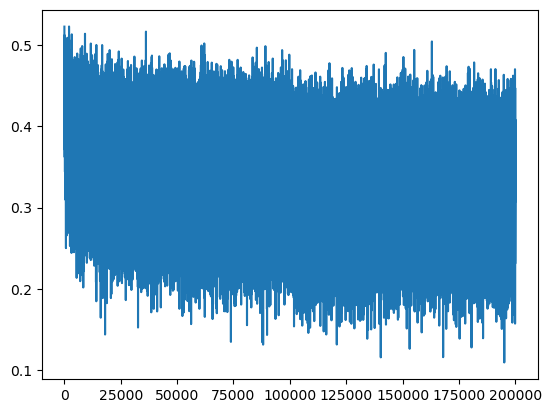

In [85]:
plt.plot(lossi)

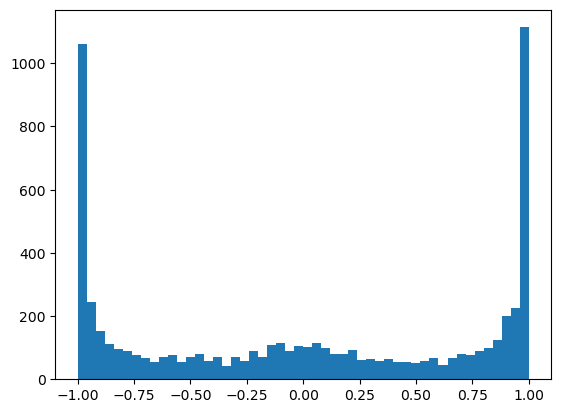

In [64]:
_=plt.hist(h.view(-1).tolist(),50)

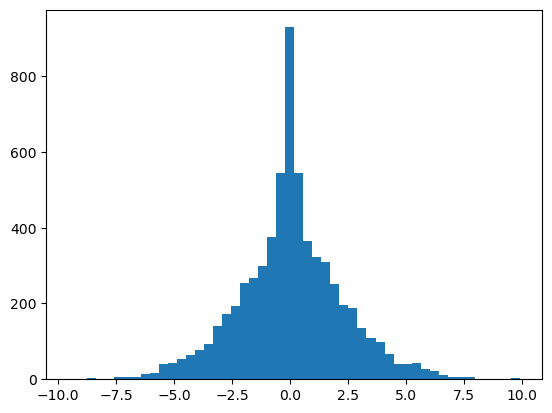

In [65]:
# preactivations that feed into tanh
_=plt.hist(hpreact.view(-1).tolist(), 50)

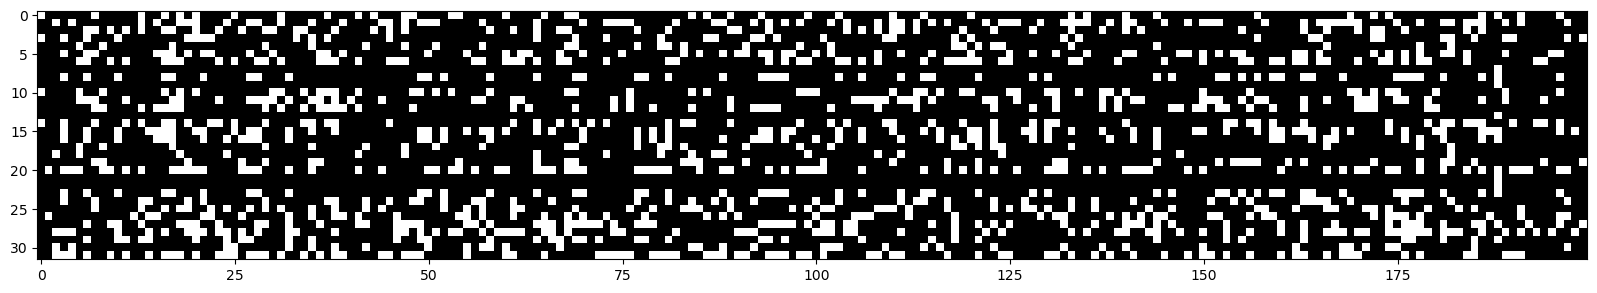

In [66]:
# how often tanh shows up in flat region
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest') # black if false; white if true
# in white cases backward gradient is destory
# if all white dead neuron - no neuron gets activated
# all neuron have activations based on rows (not cols)

In [68]:
hpreact.mean(0, keepdim=True).shape, hpreact.std(0, keepdim=True).shape

(tensor([[ 0.3229, -0.0700, -0.7789,  0.3653,  0.0459, -0.3451,  1.3917, -0.6577,
          -0.5668,  0.2629, -0.8892, -1.2078,  0.3110, -0.1368,  0.6079, -0.5981,
           0.8450, -1.1562, -0.3195,  0.4018,  0.9933,  0.3919,  0.8263, -0.3102,
           0.4256,  0.5618, -0.6433, -0.5377,  0.7079,  1.1673, -0.3709, -0.0239,
          -1.5522, -0.3294,  0.1136, -1.8400,  0.3903, -0.0334, -1.6392, -0.2682,
           0.1656, -0.5848, -0.2727,  0.2300,  0.2435, -1.0818,  0.6108,  0.0823,
           0.7457,  1.1256,  0.3454, -0.7906,  0.7446,  0.7092,  0.1758, -0.3113,
          -0.2637,  1.4758,  0.3397, -0.3905,  0.2343,  0.9470,  0.0542, -0.2393,
           0.6675,  1.0601,  0.7086,  0.7567, -0.7565,  0.5327, -1.9062,  0.0554,
           0.5530, -1.4017, -0.5226, -0.3476,  0.1607, -1.3189, -1.2532, -0.5508,
          -0.3835,  2.3955,  0.7409,  0.0266,  0.2662,  0.2313, -0.9156, -0.0235,
          -0.5392,  0.0974, -0.5106,  0.3499, -0.2506, -0.9058, -1.6761, -0.0941,
          -0.712

In [ ]:
# with just normailzation
#h = (hpreact - hpreact.mean(0, keepdim=True)_/ hpreact.std(0, keepdim=True)
# must scale by gain (gamma) and bias (beta)

In [140]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
    
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.zeros(dim)
        
    
    def __call__(self, x):
        # calcualte the forward pass
        if self.training:
            xmean = x.mean(0,keepdim=True)
            xvar = x.var(0, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean) / torch.sqrt(xvar + self.eps) # normalzie to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1- self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1- self.momentum) * self.running_var + self.momentum * xvar
        return self.out
        
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [147]:
n_embd =10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C =torch.randn((vocab_size, n_embd), generator=g)

layers = [
Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
Linear(n_hidden, vocab_size),BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # lasy layer: make less confident
    layers[-1].gamma *= 0.1
#    layers[-1].weight *= 0.1
    # all otehr layers : apply gain
    for layer in layers[:-1]:
        if isinstance(layer,Linear):
            layer.weight *=5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

37251


In [148]:
max_steps = 200000
batch_size = 32
lossi =[]
ud = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,),generator=g)
    Xb,Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0],-1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x,Yb)
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data += -lr *p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    # raitio fo how greater updates are to the values - shows you how well learning is happening
    with torch.no_grad():
        ud.append([(lr*p.grad.std()/ p.data.std()).log().item() for p in parameters])
        
    if i>=1000:
        break

      0/ 200000:3.2673


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 3.31%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean +0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean -0.00, std 0.65, saturated: 2.12%


Text(0.5, 1.0, 'activation distribution')

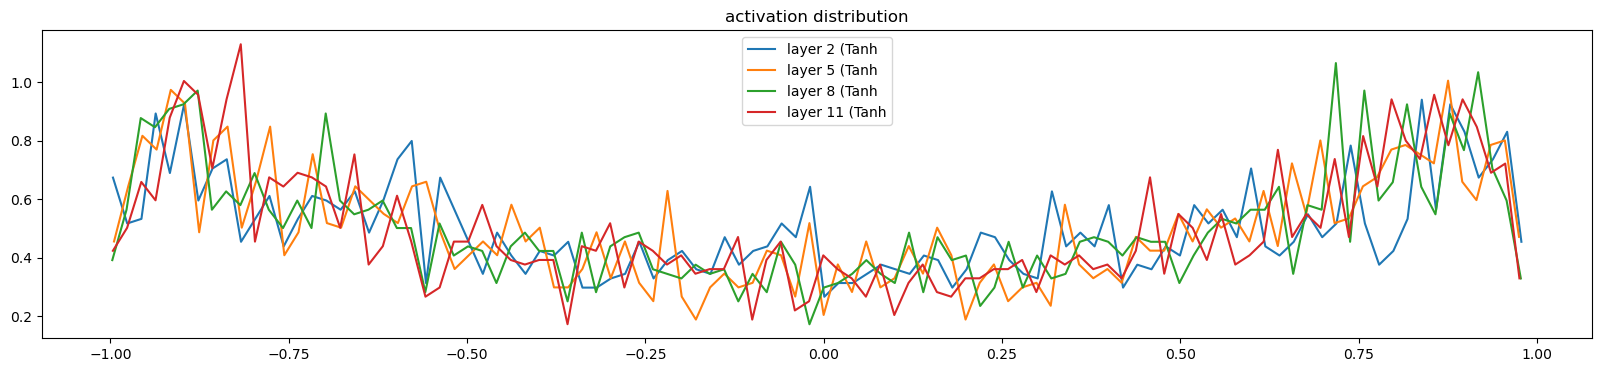

In [149]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.631200e-03
layer 5 (      Tanh): mean +0.000000, std 3.043899e-03
layer 8 (      Tanh): mean +0.000000, std 2.855194e-03
layer 11 (      Tanh): mean -0.000000, std 2.821381e-03


Text(0.5, 1.0, 'gradient distribution')

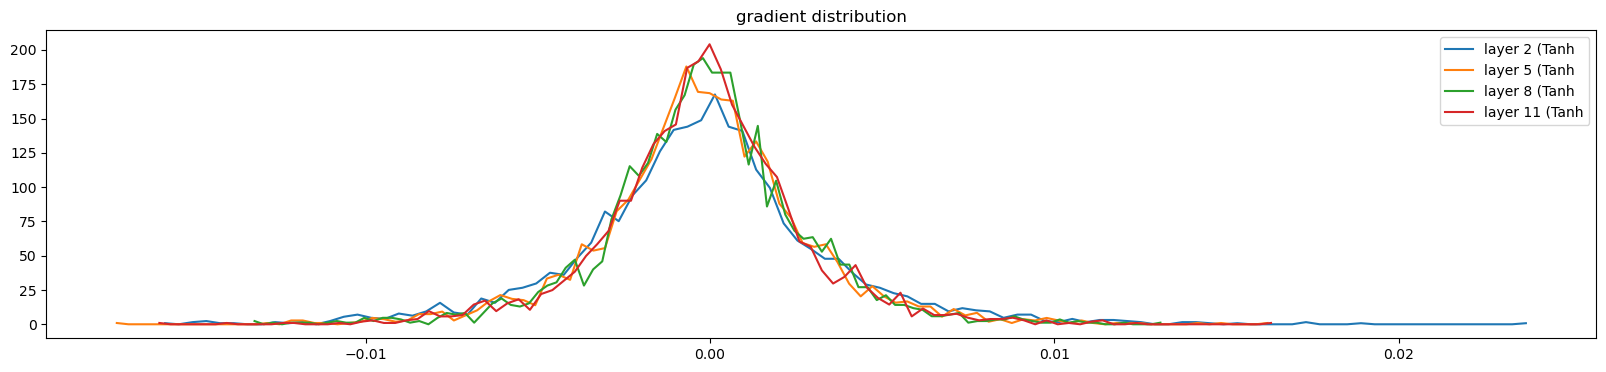

In [150]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 9.938616e-03 | grad:data ratio 9.928636e-03
weight  (30, 100) | mean +0.000156 | std 8.930074e-03 | grad:data ratio 2.857291e-02
weight (100, 100) | mean +0.000018 | std 7.620037e-03 | grad:data ratio 4.560170e-02
weight (100, 100) | mean -0.000111 | std 6.449296e-03 | grad:data ratio 3.824965e-02
weight (100, 100) | mean +0.000016 | std 6.110515e-03 | grad:data ratio 3.641041e-02
weight  (100, 27) | mean -0.000065 | std 1.131197e-02 | grad:data ratio 6.570451e-02


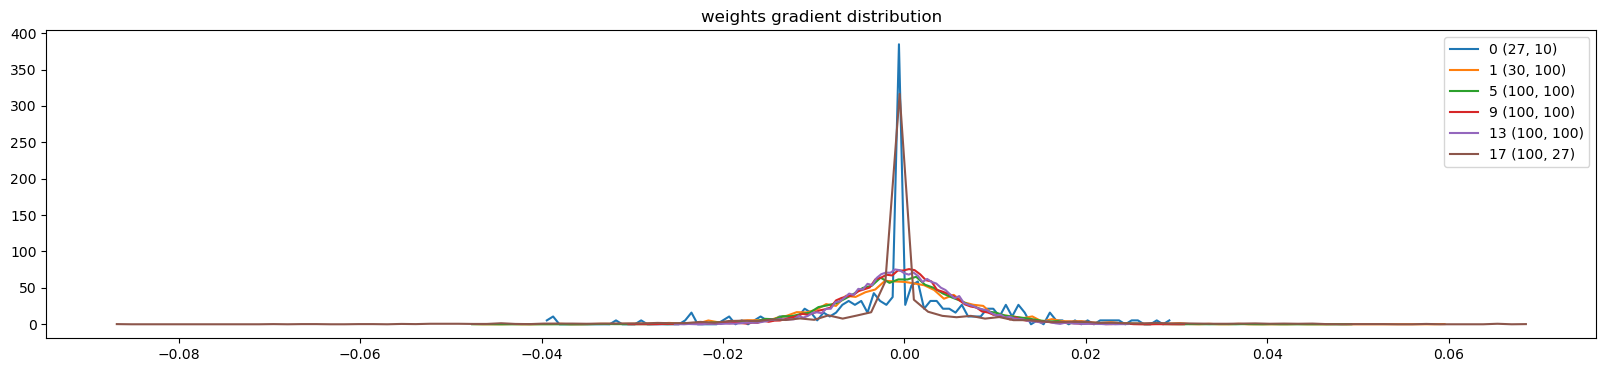

In [151]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

# if gradient ratio is to large compard to teh size of the data - trouble - getting too big!

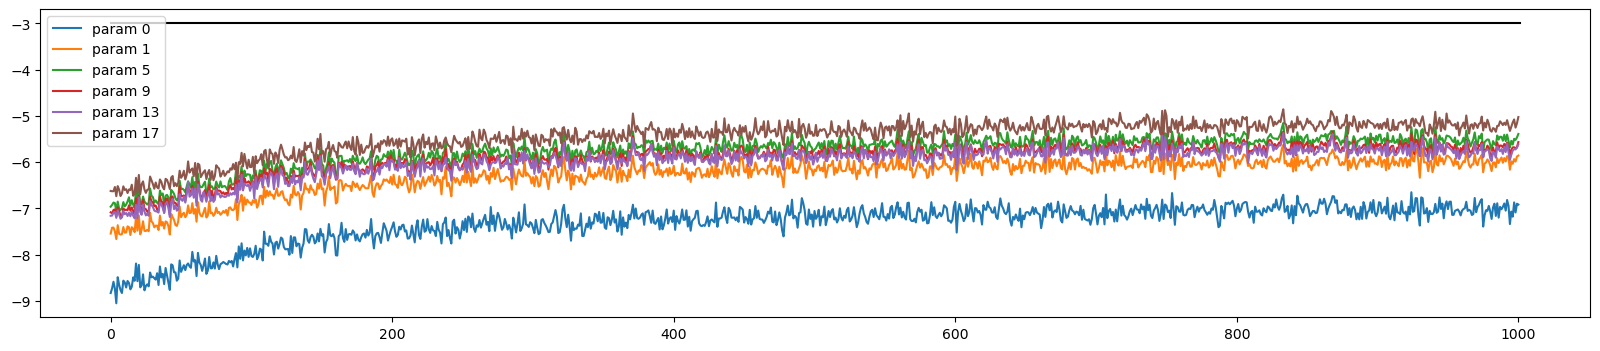

In [152]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [154]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True
47024
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

47024
      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.78%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.56%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.25%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.69%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.88%


Text(0.5, 1.0, 'activation distribution')

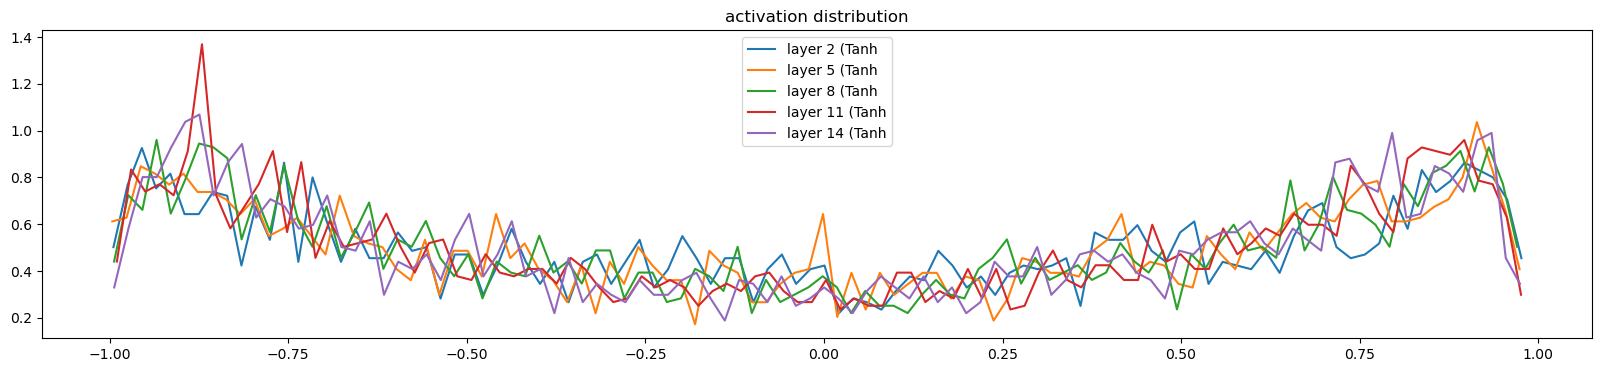

In [155]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 2.640702e-03
layer 5 (      Tanh): mean +0.000000, std 2.245584e-03
layer 8 (      Tanh): mean -0.000000, std 2.045742e-03
layer 11 (      Tanh): mean +0.000000, std 1.983134e-03
layer 14 (      Tanh): mean -0.000000, std 1.952382e-03


Text(0.5, 1.0, 'gradient distribution')

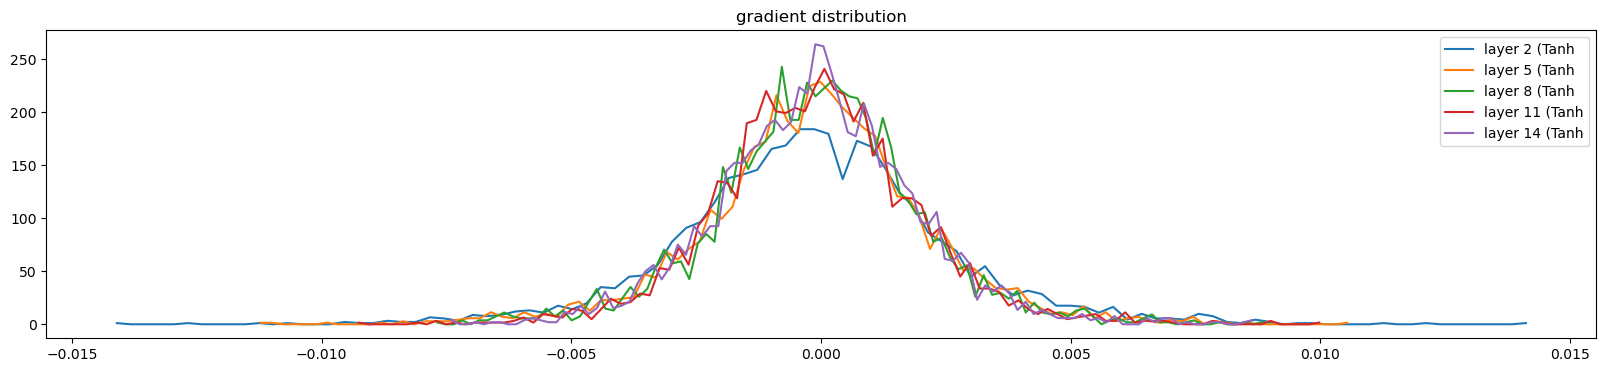

In [156]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 8.020539e-03 | grad:data ratio 8.012635e-03
weight  (30, 100) | mean +0.000246 | std 9.241082e-03 | grad:data ratio 4.881094e-02
weight (100, 100) | mean +0.000113 | std 7.132884e-03 | grad:data ratio 6.964625e-02
weight (100, 100) | mean -0.000086 | std 6.234306e-03 | grad:data ratio 6.073742e-02
weight (100, 100) | mean +0.000052 | std 5.742189e-03 | grad:data ratio 5.631484e-02
weight (100, 100) | mean +0.000032 | std 5.672207e-03 | grad:data ratio 5.570126e-02
weight  (100, 27) | mean -0.000082 | std 1.209416e-02 | grad:data ratio 1.160106e-01


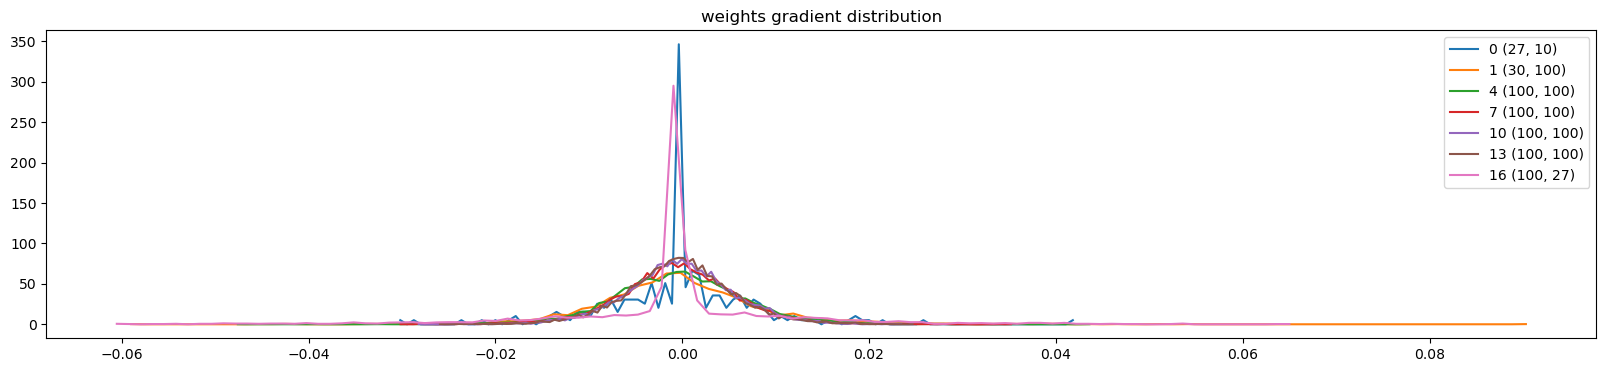

In [157]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

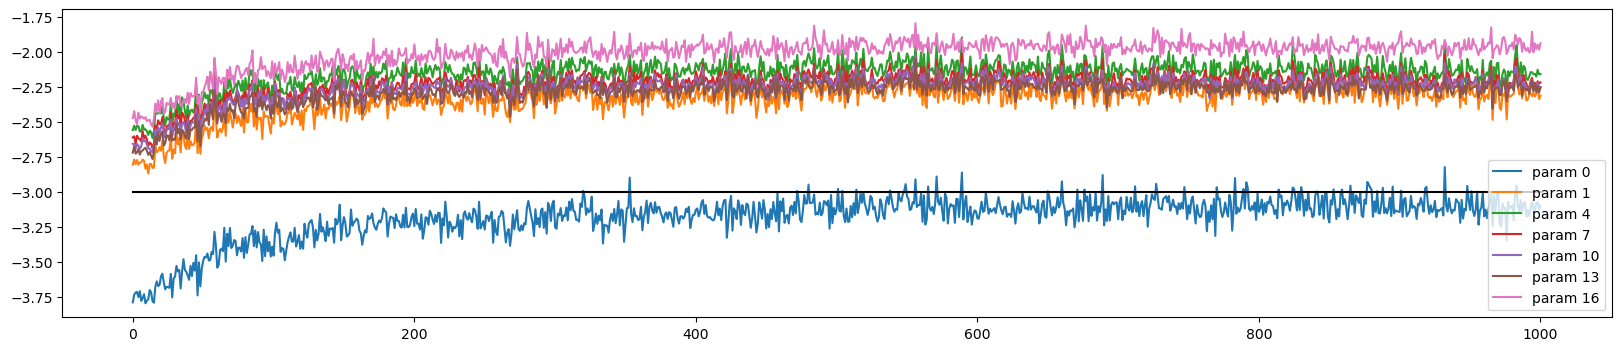

In [158]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [159]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.4002976417541504
val 2.3982467651367188


In [160]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carpah.
qarlileif.
jmrix.
thty.
sacansa.
jazhnte.
dpn.
arciigqeiunellaia.
chriiv.
kalein.
dhlm.
join.
qhinn.
sroin.
arian.
quiqaelogiearyxix.
kaeklinsan.
ed.
ecoia.
gtleley.
